<a href="https://colab.research.google.com/github/shantanutrip/covid_flight_analysis/blob/master/Analysis/Flight_Impacts_COVID_Advance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impact of Flight on Covid
This analysis is mainly based on the previous analysis from Binghan, which you can find from here: https://github.com/shantanutrip/covid_flight_analysis/blob/master/Analysis/Flight_Impacts_COVID_Basic.ipynb

Our goal is to see if the spread of disease in one city resulted from the flights from other cities which have cases already.

## Install required packages

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pyspark

     |████████████████████████████████| 217.8MB 63kB/s 
     |████████████████████████████████| 204kB 39.7MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=50f403f0cfe5964837cb2c1dc36f178a883f29272e74aac48e41f3560cb3bee7
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


## Set up environment

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

## Download data from webpages

In [1]:
# This dataset is disease condition in terms of different counties and states
!wget https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv
# This dataset is about the airport info around the world
!wget https://ourairports.com/data/airports.csv
# This dataset is from our project repo, which contains the disease/flight data for the cities we concern about
!wget https://raw.githubusercontent.com/shantanutrip/covid_flight_analysis/master/Resultant_Data/covid_flight_count_data.csv

--2020-05-10 02:06:59--  https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4974471 (4.7M) [text/plain]
Saving to: ‘us-counties.csv’

us-counties.csv     100%[===================>]   4.74M  25.2MB/s    in 0.2s    

2020-05-10 02:07:00 (25.2 MB/s) - ‘us-counties.csv’ saved [4974471/4974471]

--2020-05-10 02:07:01--  https://ourairports.com/data/airports.csv
Resolving ourairports.com (ourairports.com)... 206.71.179.167
Connecting to ourairports.com (ourairports.com)|206.71.179.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8477770 (8.1M) [text/csv]
Saving to: ‘airports.csv’

airports.csv        100%[===================>]   8.08M  15.0MB/s    in 0.5s    

2020-

# Analysis Starts

In [0]:
# Import useful packages or functions
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
import datetime
from geopy.geocoders import Nominatim # Use this to transform lat/long to county/state
import matplotlib.pyplot as plt
import numpy as np

In [0]:
import findspark
findspark.init("spark-2.4.5-bin-hadoop2.7")
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Load four datasets, the former three is small and the last one is large
city_concern = spark.read.format("csv").options(header="true", inferSchema="true").load("/content/covid_flight_count_data.csv")
airports = spark.read.format("csv").options(header="true").load("/content/airports.csv")
disease = spark.read.format("csv").options(header="true", inferSchema="true").load("/content/us-counties.csv")
# Change merged_flight.csv path accordingly
all_flights = spark.read.format("csv").options(header="true", inferSchema="true").load("/content/drive/My Drive/Big Data/Final Project/merged_flight.csv")

In [0]:
# output the cities we care about, including 23 large cities around the US
city_concern.createOrReplaceTempView('city_concern')
city_with_first_case = spark.sql("select distinct city from city_concern order by city")
city_list = city_with_first_case.collect()
city_list = [row['city'] for row in city_list]

print(city_list)

['BOSTON', 'CHARLOTTE', 'CHICAGO', 'DALLAS', 'DENVER', 'DETROIT', 'FRANKLIN', 'HOUSTON', 'INDIANAPOLIS', 'LOS ANGELES', 'MIAMI', 'MILWAUKEE', 'NASHVILLE', 'NEW YORK CITY', 'PHILADELPHIA', 'PHOENIX', 'SALT LAKE CITY', 'SAN ANTONIO', 'SAN DIEGO', 'SAN FRANCISCO', 'SAN JOSE', 'SEATTLE', 'WASHINGTON']


In [0]:
# Choose the city randomly for the test run
test_city = city_list[0]
print(test_city)

BOSTON


In [0]:
# This function return the date of the first case in the cities we care about
def get_startdate_main(city_name):
  temp_date = city_concern.filter(city_concern['city']==city_name).orderBy('day').first()['day']
  return temp_date

# Test
# target_date is the global var
target_date = get_startdate_main(test_city)
print(target_date)

2020-02-01 00:00:00


In [0]:
# This function output all flights to the city_name as dest
def get_all_flight_to_city(city_name):
  target_airports = airports.filter((airports["municipality"] == city_name) & ((airports["type"] == "large_airport") | (airports["type"] == "medium_airport"))).select("ident", "name", "municipality")
  #target_airports.show()
  target_flights = all_flights.filter(all_flights["origin"] != "null").join(target_airports, target_airports["ident"] == all_flights["destination"]).withColumnRenamed("ident", "dst_ident").withColumnRenamed("name", "dst_name").withColumnRenamed("municipality", "dst_municipality").drop("callsign", "number", "icao24", "registration", "typecode", "firstseen", "lastseen")
  target_flights = airports.select("ident", "name", "municipality", "latitude_deg", "longitude_deg").join(target_flights, target_flights["origin"] == airports["ident"]).withColumnRenamed("ident", "src_ident").withColumnRenamed("name", "src_name").withColumnRenamed("municipality", "src_municipality")
  #target_flights.show()
  return target_flights

# Test
all_flight_data = get_all_flight_to_city(test_city[0]+test_city[1:].lower())
all_flight_data.show()

+---------+--------------------+-----------------+------------------+-------------------+------+-----------+--------------------+---------+--------------------+----------------+
|src_ident|            src_name| src_municipality|      latitude_deg|      longitude_deg|origin|destination|                 day|dst_ident|            dst_name|dst_municipality|
+---------+--------------------+-----------------+------------------+-------------------+------+-----------+--------------------+---------+--------------------+----------------+
|     KLAX|Los Angeles Inter...|      Los Angeles|         33.942501|        -118.407997|  KLAX|       KBOS|2020-01-01 00:00:...|     KBOS|General Edward La...|          Boston|
|     VHHH|Hong Kong Interna...|        Hong Kong|         22.308901|         113.915001|  VHHH|       KBOS|2020-01-01 00:00:...|     KBOS|General Edward La...|          Boston|
|     KBOS|General Edward La...|           Boston|       42.36429977|       -71.00520325|  KBOS|       KBOS|20

In [0]:
# This function checks whether the consider_date is in the range [target_date-start, target_date-end]
def date_range_filter(consider_date):
  consider_datetime_obj = datetime.datetime.strptime(consider_date.split("+")[0], "%Y-%m-%d %H:%M:%S")
  range_max = datetime.timedelta(days=start)
  range_min = datetime.timedelta(days=end)
  day_difference = target_date - consider_datetime_obj

  if day_difference <= range_max and day_difference > range_min:
    return True
  else:
    return False
  
date_range_filter = udf(date_range_filter, BooleanType())

In [0]:
# start and end are global vars
start, end = 14, 0
filtered_flight_data = all_flight_data.filter(date_range_filter(all_flight_data["day"]))
# Show the flight data 10 days before the 2020-02-01
filtered_flight_data.show()

+---------+--------------------+-----------------+------------+-------------+------+-----------+--------------------+---------+--------------------+----------------+
|src_ident|            src_name| src_municipality|latitude_deg|longitude_deg|origin|destination|                 day|dst_ident|            dst_name|dst_municipality|
+---------+--------------------+-----------------+------------+-------------+------+-----------+--------------------+---------+--------------------+----------------+
|     KLAX|Los Angeles Inter...|      Los Angeles|   33.942501|  -118.407997|  KLAX|       KBOS|2020-01-18 00:00:...|     KBOS|General Edward La...|          Boston|
|     VHHH|Hong Kong Interna...|        Hong Kong|   22.308901|   113.915001|  VHHH|       KBOS|2020-01-18 00:00:...|     KBOS|General Edward La...|          Boston|
|     KBOS|General Edward La...|           Boston| 42.36429977| -71.00520325|  KBOS|       KBOS|2020-01-18 00:00:...|     KBOS|General Edward La...|          Boston|
|   

In [0]:
# This part groups the flight data by lat and long.
incoming_flight_info = filtered_flight_data.groupBy("latitude_deg", "longitude_deg").count().orderBy(desc("count"))
incoming_flight_info.show()

+------------------+------------------+-----+
|      latitude_deg|     longitude_deg|count|
+------------------+------------------+-----+
|           38.8521|        -77.037697|  388|
|       40.77719879|      -73.87259674|  379|
| 39.87189865112305|-75.24109649658203|  281|
|           41.9786|          -87.9048|  265|
|40.692501068115234|  -74.168701171875|  254|
|         40.639801|          -73.7789|  216|
|           33.6367|        -84.428101|  198|
|         33.942501|       -118.407997|  151|
|           39.1754|        -76.668297|  150|
| 37.61899948120117|          -122.375|  145|
|  35.2140007019043|-80.94309997558594|  141|
|35.877601623535156| -78.7874984741211|  133|
| 25.79319953918457|-80.29060363769531|  122|
|     43.6772003174|-79.63059997559999|  114|
|         26.072599|        -80.152702|  111|
|            44.882|        -93.221802|  107|
| 26.53619956970215|-81.75520324707031|   95|
|  36.1245002746582| -86.6781997680664|   93|
|27.975500106811523|     -82.53320

In [0]:
# Function definition for adding county column
geolocator = Nominatim(user_agent = "flights_analysis", timeout=100)

def add_county(lat, lng):
  '''
  This function adds county column to caller dataframe
  '''
  geo_str = str(lat) + ", " + str(lng)
  location = geolocator.reverse(geo_str).raw
  try:
    county_full = location["address"]["county"]
    county = " ".join(county_full.split(" ")[:-1])
    return county
  except KeyError:
    return "null"

# Function definition for adding state column
def add_state(lat, lng):
  '''
  This function adds state column to caller dataframe
  '''
  geo_str = str(lat) + ", " + str(lng)
  location = geolocator.reverse(geo_str).raw
  try:
    state = location["address"]["state"]
    return state
  except KeyError:
    return "null"

add_county_func = udf(add_county, StringType())
add_state_func = udf(add_state, StringType())

In [0]:
# This part adds county/state info onto the former dataframe according to the long/lat info
incoming_flight_info = incoming_flight_info.withColumn("county", add_county_func(incoming_flight_info["latitude_deg"], incoming_flight_info["longitude_deg"])).withColumn("state", add_state_func(incoming_flight_info["latitude_deg"], incoming_flight_info["longitude_deg"]))
incoming_flight_info.show()

+------------------+------------------+-----+------------+--------------+
|      latitude_deg|     longitude_deg|count|      county|         state|
+------------------+------------------+-----+------------+--------------+
|           38.8521|        -77.037697|  388|   Arlington|      Virginia|
|       40.77719879|      -73.87259674|  379|      Queens|      New York|
| 39.87189865112305|-75.24109649658203|  281|Philadelphia|  Pennsylvania|
|           41.9786|          -87.9048|  265|      DuPage|      Illinois|
|40.692501068115234|  -74.168701171875|  254|       Essex|    New Jersey|
|         40.639801|          -73.7789|  216|      Queens|      New York|
|           33.6367|        -84.428101|  198|     Clayton|       Georgia|
|         33.942501|       -118.407997|  151| Los Angeles|    California|
|           39.1754|        -76.668297|  150|Anne Arundel|      Maryland|
| 37.61899948120117|          -122.375|  145|   San Mateo|    California|
|  35.2140007019043|-80.94309997558594

In [0]:
# Group by county/state and count, then collect the dataframe
key_info = incoming_flight_info.groupBy("county", "state").sum("count").orderBy(desc("sum(count)")).collect()

In [0]:
# Reload the flight dataframe with county/state rather than lat/long and change the 'sum(count)' to 'flight_num'
key_info_df = spark.createDataFrame(key_info).withColumnRenamed("sum(count)", "flight_num")
key_info_df.show()

+------------+--------------+----------+
|      county|         state|flight_num|
+------------+--------------+----------+
|      Queens|      New York|       595|
|   Arlington|      Virginia|       388|
|Philadelphia|  Pennsylvania|       281|
|      DuPage|      Illinois|       265|
|       Essex|    New Jersey|       254|
|     Clayton|       Georgia|       198|
| Los Angeles|    California|       173|
|Anne Arundel|      Maryland|       150|
|   San Mateo|    California|       145|
| Mecklenburg|North Carolina|       141|
|        Wake|North Carolina|       133|
|  Miami-Dade|       Florida|       122|
|        Peel|       Ontario|       114|
|     Broward|       Florida|       111|
|    Hennepin|     Minnesota|       107|
|         Lee|       Florida|        95|
|    Davidson|     Tennessee|        93|
|Hillsborough|       Florida|        91|
|     Tarrant|         Texas|        85|
|       Clark|        Nevada|        74|
+------------+--------------+----------+
only showing top

In [0]:
# This part generate the date for each county's first case from us-counties.csv
spread_start = disease.orderBy("date").groupBy("county", "state").agg(first("date")).withColumnRenamed("county", "spread_county").withColumnRenamed("state", "spread_state").withColumnRenamed("first(date, false)", "start_date").collect()
spread_start_df = spark.createDataFrame(spread_start)
spread_start_df.show()
# spread_start.count()  # 2922

+-------------+--------------+-------------------+
|spread_county|  spread_state|         start_date|
+-------------+--------------+-------------------+
|      Pulaski|      Arkansas|2020-03-12 00:00:00|
|       Orange|       Florida|2020-03-13 00:00:00|
|       Mercer|    New Jersey|2020-03-14 00:00:00|
|   Winneshiek|          Iowa|2020-03-18 00:00:00|
|   Washington|       Alabama|2020-03-20 00:00:00|
|      Pickens|       Georgia|2020-03-20 00:00:00|
|      Chisago|     Minnesota|2020-03-20 00:00:00|
|        Grant|     Louisiana|2020-03-23 00:00:00|
|   Pennington|  South Dakota|2020-03-23 00:00:00|
|        Stone|      Arkansas|2020-03-24 00:00:00|
|    Claiborne|     Tennessee|2020-03-24 00:00:00|
|         Iron|     Wisconsin|2020-03-27 00:00:00|
|    Covington|   Mississippi|2020-03-28 00:00:00|
|    Henderson|         Texas|2020-03-29 00:00:00|
|       Sumter|       Alabama|2020-03-30 00:00:00|
|   Washington|         Idaho|2020-04-02 00:00:00|
|       Murray|      Oklahoma|2

In [0]:
# This part show the start_date for the county/state we generated before
key_info_df_start_date = key_info_df.join(spread_start_df, (key_info_df["county"]==spread_start_df["spread_county"]) &(key_info_df["state"]==spread_start_df["spread_state"])).drop("spread_county", "spread_state")
key_info_df_start_date.show()

+------------+-------------+----------+-------------------+
|      county|        state|flight_num|         start_date|
+------------+-------------+----------+-------------------+
|      Orange|      Florida|        13|2020-03-13 00:00:00|
|     Dauphin| Pennsylvania|        12|2020-03-22 00:00:00|
|    Franklin|         Ohio|        43|2020-03-14 00:00:00|
|     Clayton|      Georgia|       198|2020-03-15 00:00:00|
|    Onondaga|     New York|        23|2020-03-16 00:00:00|
|    Atlantic|   New Jersey|         1|2020-03-18 00:00:00|
|     Windsor|      Vermont|         1|2020-03-14 00:00:00|
|   Middlesex|Massachusetts|         7|2020-03-05 00:00:00|
|     Chemung|     New York|         1|2020-03-24 00:00:00|
|       Essex|Massachusetts|        40|2020-03-10 00:00:00|
|      Morris|   New Jersey|         2|2020-03-12 00:00:00|
|       Essex|   New Jersey|       254|2020-03-12 00:00:00|
|  Rockingham|New Hampshire|         6|2020-03-07 00:00:00|
|    Trumbull|         Ohio|         1|2

In [0]:
# This part generate the total flight number from other cities in US to our test_city in the legal time range
key_info_df_start_date.createOrReplaceTempView('key_info_df_start_date')
all_flights_number = spark.sql("select sum(flight_num) from key_info_df_start_date")
all_flights_number.show()

+---------------+
|sum(flight_num)|
+---------------+
|           4341|
+---------------+



In [0]:
# Function definition for adding day difference with target date
def add_day_difference(day):
  '''
  This function adds day difference between target date and input date
  '''
  day_difference = target_date - day
  return day_difference.days

add_difference_func = udf(add_day_difference, IntegerType())

In [0]:
# This part computes the day difference between the target date and the start_date for each county/state
# Then, filter out all the county/state that are out of the legal time range
key_info_df_start_difference = key_info_df_start_date.withColumn("day_difference", add_difference_func(key_info_df_start_date["start_date"]))
key_info_df_start_difference = key_info_df_start_difference.filter(key_info_df_start_difference["day_difference"]>end)
key_info_df_start_difference.show()

+-----------+----------+----------+-------------------+--------------+
|     county|     state|flight_num|         start_date|day_difference|
+-----------+----------+----------+-------------------+--------------+
|   Maricopa|   Arizona|        59|2020-01-26 00:00:00|             6|
|Los Angeles|California|       173|2020-01-26 00:00:00|             6|
|       Cook|  Illinois|        36|2020-01-24 00:00:00|             8|
+-----------+----------+----------+-------------------+--------------+



In [0]:
# This part of code show the disease data in the legal time period

def date_range_filter_disease(consider_date):
  #consider_datetime_obj = datetime.datetime.strptime(consider_date.split("+")[0], "%Y-%m-%d %H:%M:%S")
  range_max = datetime.timedelta(days=start)
  range_min = datetime.timedelta(days=end)
  day_difference = target_date - consider_date

  if day_difference <= range_max and day_difference > range_min:
    return True
  else:
    return False
  
date_range_filter_disease = udf(date_range_filter_disease, BooleanType())

filtered_disease_data = disease.filter(date_range_filter_disease(disease["date"])).withColumnRenamed("county", "spread_county").withColumnRenamed("state", "spread_state")
filtered_disease_data.show(50)
filtered_disease_data.count()

+-------------------+-------------+------------+-----+-----+------+
|               date|spread_county|spread_state| fips|cases|deaths|
+-------------------+-------------+------------+-----+-----+------+
|2020-01-21 00:00:00|    Snohomish|  Washington|53061|    1|     0|
|2020-01-22 00:00:00|    Snohomish|  Washington|53061|    1|     0|
|2020-01-23 00:00:00|    Snohomish|  Washington|53061|    1|     0|
|2020-01-24 00:00:00|         Cook|    Illinois|17031|    1|     0|
|2020-01-24 00:00:00|    Snohomish|  Washington|53061|    1|     0|
|2020-01-25 00:00:00|       Orange|  California| 6059|    1|     0|
|2020-01-25 00:00:00|         Cook|    Illinois|17031|    1|     0|
|2020-01-25 00:00:00|    Snohomish|  Washington|53061|    1|     0|
|2020-01-26 00:00:00|     Maricopa|     Arizona| 4013|    1|     0|
|2020-01-26 00:00:00|  Los Angeles|  California| 6037|    1|     0|
|2020-01-26 00:00:00|       Orange|  California| 6059|    1|     0|
|2020-01-26 00:00:00|         Cook|    Illinois|

39

In [0]:
# This part join the filtered disease data with the key_info data

# this threshold is for the average number of case for the cities from key_info
# if the average case number for one city in that legal time period is higher than
# this threshold, then this city will be counted as the candidate
threshold_case = 1.0

key_info_case_number = key_info_df_start_difference.join(filtered_disease_data, (key_info_df_start_difference["county"]==filtered_disease_data["spread_county"]) & (key_info_df_start_difference["state"]==filtered_disease_data["spread_state"]))
key_info_case_number = key_info_case_number.groupBy("county", "state").avg("cases").withColumnRenamed("avg(cases)", "avg_case")
key_info_case_number = key_info_case_number.filter(key_info_case_number["avg_case"]>=threshold_case).withColumnRenamed("county", "spread_county").withColumnRenamed("state", "spread_state")
key_info_case_number.show()

+-------------+------------+--------+
|spread_county|spread_state|avg_case|
+-------------+------------+--------+
|     Maricopa|     Arizona|     1.0|
|  Los Angeles|  California|     1.0|
|         Cook|    Illinois|    1.25|
+-------------+------------+--------+



In [0]:
# This part join the flight data of county/state with the disease data of county/state

key_info_result = key_info_df_start_difference.join(key_info_case_number, (key_info_df_start_difference["county"]==key_info_case_number["spread_county"]) & (key_info_df_start_difference["state"]==key_info_case_number["spread_state"]))
key_info_result.show()

+-----------+----------+----------+-------------------+--------------+-------------+------------+--------+
|     county|     state|flight_num|         start_date|day_difference|spread_county|spread_state|avg_case|
+-----------+----------+----------+-------------------+--------------+-------------+------------+--------+
|   Maricopa|   Arizona|        59|2020-01-26 00:00:00|             6|     Maricopa|     Arizona|     1.0|
|Los Angeles|California|       173|2020-01-26 00:00:00|             6|  Los Angeles|  California|     1.0|
|       Cook|  Illinois|        36|2020-01-24 00:00:00|             8|         Cook|    Illinois|    1.25|
+-----------+----------+----------+-------------------+--------------+-------------+------------+--------+



In [0]:
# This part sum of the flight number from the previous dataframe
# avg_case >= threshold; start_date in the time range

key_info_result.createOrReplaceTempView('key_info_result')
flight_number_affect = spark.sql("select sum(flight_num) from key_info_result")
flight_number_affect = flight_number_affect.na.fill(0)
flight_number_affect.show()

+---------------+
|sum(flight_num)|
+---------------+
|            268|
+---------------+



In [0]:
# This part collects the both flights number as numerator and denominator

all_flights_number = all_flights_number.collect()
flight_number_affect = flight_number_affect.collect()

all_flights_number = [row["sum(flight_num)"] for row in all_flights_number]
flight_number_affect = [row["sum(flight_num)"] for row in flight_number_affect]

In [0]:
print("The analysis for %s, the start_date is %s.\n" % (test_city, target_date))
print("The date range is [%d, %d]" % (-start, -end))
print("The threshold for average case number in the date range is %.1f.\n" % (threshold_case))
print("The flight (from US) number that might influence the spread in target city: %d." % (flight_number_affect[0]))
print("The all flight (from US) number to target city in the legal time period: %d." % (all_flights_number[0]))
print("The ratio is: %.2f%%." % (flight_number_affect[0]/all_flights_number[0]*100))

The analysis for BOSTON, the start_date is 2020-02-01 00:00:00.

The date range is [-14, 0]
The threshold for average case number in the date range is 1.0.

The flight (from US) number that might influence the spread in target city: 268.
The all flight (from US) number to target city in the legal time period: 4341.
The ratio is: 6.17%.


# Aggregate the analysis in for-loop

In [0]:
import time

target_date = None
start, end = 14, 0
threshold_case = 1.0
start_date_list = []
flight_all = []
flight_filtered = []

start_time = time.time()
for i in range(len(city_list)):
  # get the test city name
  test_city = city_list[i]

  # get the first case date of test city
  target_date = get_startdate_main(test_city)
  start_date_list.append(target_date)

  # get all flight data to this test city from worldwide
  all_flight_data = get_all_flight_to_city(test_city[0]+test_city[1:].lower())

  # filter the flight data in the legal time range
  filtered_flight_data = all_flight_data.filter(date_range_filter(all_flight_data["day"]))

  # group by the flight data by lat/long
  incoming_flight_info = filtered_flight_data.groupBy("latitude_deg", "longitude_deg").count().orderBy(desc("count"))

  # add the county/state info by geopy using the lat/long info
  incoming_flight_info = incoming_flight_info.withColumn("county", add_county_func(incoming_flight_info["latitude_deg"], incoming_flight_info["longitude_deg"])).withColumn("state", add_state_func(incoming_flight_info["latitude_deg"], incoming_flight_info["longitude_deg"]))

  # gourp by the data by county/state and count, then collect it
  key_info = incoming_flight_info.groupBy("county", "state").sum("count").orderBy(desc("sum(count)")).collect()
  if not key_info:
    flight_all.append(-1)
    flight_filtered.append(-1)
    time_now = time.time()
    print("The %dth city finished! The time till now is %.2f." % (i+1, time_now-start_time))
    print("For this city, the flitered data is None!!!")
    continue

  # reload the key_info and rename
  key_info_df = spark.createDataFrame(key_info).withColumnRenamed("sum(count)", "flight_num")

  # add the start date of the source cities to the dataframe
  key_info_df_start_date = key_info_df.join(spread_start_df, (key_info_df["county"]==spread_start_df["spread_county"]) &(key_info_df["state"]==spread_start_df["spread_state"])).drop("spread_county", "spread_state")

  # select the number of flight from cities in US to our test city
  key_info_df_start_date.createOrReplaceTempView('key_info_df_start_date')
  all_flights_number = spark.sql("select sum(flight_num) from key_info_df_start_date")

  # add day different and filter them into the legal range
  key_info_df_start_difference = key_info_df_start_date.withColumn("day_difference", add_difference_func(key_info_df_start_date["start_date"]))
  key_info_df_start_difference = key_info_df_start_difference.filter(key_info_df_start_difference["day_difference"]>end)

  # filter the disease data that lie in this range
  filtered_disease_data = disease.filter(date_range_filter_disease(disease["date"])).withColumnRenamed("county", "spread_county").withColumnRenamed("state", "spread_state")

  # join the filtered disease data and flight data and filter the avergae case by threshold
  key_info_case_number = key_info_df_start_difference.join(filtered_disease_data, (key_info_df_start_difference["county"]==filtered_disease_data["spread_county"]) & (key_info_df_start_difference["state"]==filtered_disease_data["spread_state"]))
  key_info_case_number = key_info_case_number.groupBy("county", "state").avg("cases").withColumnRenamed("avg(cases)", "avg_case")
  key_info_case_number = key_info_case_number.filter(key_info_case_number["avg_case"]>=threshold_case).withColumnRenamed("county", "spread_county").withColumnRenamed("state", "spread_state")

  key_info_result = key_info_df_start_difference.join(key_info_case_number, (key_info_df_start_difference["county"]==key_info_case_number["spread_county"]) & (key_info_df_start_difference["state"]==key_info_case_number["spread_state"]))

  # select the number of flight from the filtered cities to the test city
  key_info_result.createOrReplaceTempView('key_info_result')
  flight_number_affect = spark.sql("select sum(flight_num) from key_info_result")
  #flight_number_affect = flight_number_affect.na.fill(0)

  all_flights_number = all_flights_number.collect()
  flight_number_affect = flight_number_affect.collect()
  all_flights_number = [row["sum(flight_num)"] for row in all_flights_number]
  flight_number_affect = [row["sum(flight_num)"] for row in flight_number_affect]
  flight_all.append(all_flights_number[0])
  flight_filtered.append(flight_number_affect[0])

  time_now = time.time()
  print("The %dth city finished! The time till now is %.2f." % (i+1, time_now-start_time))
  print("The flight (from US) number that might influence the spread in target city: %d." % (flight_filtered[i]))
  print("The all flight (from US) number to target city in the legal time period: %d.\n" % (flight_all[i]))

The 1th city finished! The time till now is 214.71.
The flight (from US) number that might influence the spread in target city: 268.
The all flight (from US) number to target city in the legal time period: 4341.

The 2th city finished! The time till now is 441.93.
The flight (from US) number that might influence the spread in target city: 46.
The all flight (from US) number to target city in the legal time period: 1917.

The 3th city finished! The time till now is 868.68.
The flight (from US) number that might influence the spread in target city: 673.
The all flight (from US) number to target city in the legal time period: 10716.

The 4th city finished! The time till now is 1012.08.
The flight (from US) number that might influence the spread in target city: 328.
The all flight (from US) number to target city in the legal time period: 1986.

The 5th city finished! The time till now is 1260.62.
The flight (from US) number that might influence the spread in target city: 521.
The all fligh

## Save the results to driver

In [0]:
np.savetxt('/content/drive/My Drive/Big Data/Final Project/generated_data/flight_all_num', flight_all)

In [0]:
np.savetxt('/content/drive/My Drive/Big Data/Final Project/generated_data/flight_filtered_num', flight_filtered)

## Handle some outliers

In [0]:
# These cities are ignored because their name
# e.g. LOS ANGELES should be Los Angeles
ignore_city = [9, 13, 16, 17, 18, 19, 20]

In [0]:
def change_format_city_name(city_name):
  word_list = city_name.split(' ')
  return ' '.join(item[0]+item[1:].lower() for item in word_list)

In [0]:
start_time = time.time()
for i in range(len(ignore_city)):
  # get the test city name
  test_city = city_list[ignore_city[i]]
  changed_city = change_format_city_name(city_list[ignore_city[i]])

  # get the first case date of test city
  target_date = get_startdate_main(test_city)
  start_date_list[ignore_city[i]] = target_date

  # get all flight data to this test city from worldwide
  all_flight_data = get_all_flight_to_city(changed_city)

  # filter the flight data in the legal time range
  filtered_flight_data = all_flight_data.filter(date_range_filter(all_flight_data["day"]))

  # group by the flight data by lat/long
  incoming_flight_info = filtered_flight_data.groupBy("latitude_deg", "longitude_deg").count().orderBy(desc("count"))

  # add the county/state info by geopy using the lat/long info
  incoming_flight_info = incoming_flight_info.withColumn("county", add_county_func(incoming_flight_info["latitude_deg"], incoming_flight_info["longitude_deg"])).withColumn("state", add_state_func(incoming_flight_info["latitude_deg"], incoming_flight_info["longitude_deg"]))

  # gourp by the data by county/state and count, then collect it
  key_info = incoming_flight_info.groupBy("county", "state").sum("count").orderBy(desc("sum(count)")).collect()
  if not key_info:
    flight_all[ignore_city[i]] = -1
    flight_filtered[ignore_city[i]] = -1
    time_now = time.time()
    print("The %dth city finished! The time till now is %.2f." % (ignore_city[i]+1, time_now-start_time))
    print("For this city, the flitered data is None!!!")
    continue

  # reload the key_info and rename
  key_info_df = spark.createDataFrame(key_info).withColumnRenamed("sum(count)", "flight_num")

  # add the start date of the source cities to the dataframe
  key_info_df_start_date = key_info_df.join(spread_start_df, (key_info_df["county"]==spread_start_df["spread_county"]) &(key_info_df["state"]==spread_start_df["spread_state"])).drop("spread_county", "spread_state")

  # select the number of flight from cities in US to our test city
  key_info_df_start_date.createOrReplaceTempView('key_info_df_start_date')
  all_flights_number = spark.sql("select sum(flight_num) from key_info_df_start_date")

  # add day different and filter them into the legal range
  key_info_df_start_difference = key_info_df_start_date.withColumn("day_difference", add_difference_func(key_info_df_start_date["start_date"]))
  key_info_df_start_difference = key_info_df_start_difference.filter(key_info_df_start_difference["day_difference"]>end)

  # filter the disease data that lie in this range
  filtered_disease_data = disease.filter(date_range_filter_disease(disease["date"])).withColumnRenamed("county", "spread_county").withColumnRenamed("state", "spread_state")

  # join the filtered disease data and flight data and filter the avergae case by threshold
  key_info_case_number = key_info_df_start_difference.join(filtered_disease_data, (key_info_df_start_difference["county"]==filtered_disease_data["spread_county"]) & (key_info_df_start_difference["state"]==filtered_disease_data["spread_state"]))
  key_info_case_number = key_info_case_number.groupBy("county", "state").avg("cases").withColumnRenamed("avg(cases)", "avg_case")
  key_info_case_number = key_info_case_number.filter(key_info_case_number["avg_case"]>=threshold_case).withColumnRenamed("county", "spread_county").withColumnRenamed("state", "spread_state")

  key_info_result = key_info_df_start_difference.join(key_info_case_number, (key_info_df_start_difference["county"]==key_info_case_number["spread_county"]) & (key_info_df_start_difference["state"]==key_info_case_number["spread_state"]))

  # select the number of flight from the filtered cities to the test city
  key_info_result.createOrReplaceTempView('key_info_result')
  flight_number_affect = spark.sql("select sum(flight_num) from key_info_result")
  #flight_number_affect = flight_number_affect.na.fill(0)

  all_flights_number = all_flights_number.collect()
  flight_number_affect = flight_number_affect.collect()
  all_flights_number = [row["sum(flight_num)"] for row in all_flights_number]
  flight_number_affect = [row["sum(flight_num)"] for row in flight_number_affect]
  flight_all[ignore_city[i]] = all_flights_number[0]
  flight_filtered[ignore_city[i]] = flight_number_affect[0]

  time_now = time.time()
  print("The %dth city finished! The time till now is %.2f." % (ignore_city[i]+1, time_now-start_time))
  print("The flight (from US) number that might influence the spread in target city: %d." % (flight_filtered[ignore_city[i]]))
  print("The all flight (from US) number to target city in the legal time period: %d.\n" % (flight_all[ignore_city[i]]))

The 10th city finished! The time till now is 246.47.
The flight (from US) number that might influence the spread in target city: 723.
The all flight (from US) number to target city in the legal time period: 5955.

The 14th city finished! The time till now is 288.36.
For this city, the flitered data is None!!!
The 17th city finished! The time till now is 406.42.
The flight (from US) number that might influence the spread in target city: 204.
The all flight (from US) number to target city in the legal time period: 661.

The 18th city finished! The time till now is 513.34.
The flight (from US) number that might influence the spread in target city: 172.
The all flight (from US) number to target city in the legal time period: 1104.

The 19th city finished! The time till now is 659.90.
The flight (from US) number that might influence the spread in target city: 721.
The all flight (from US) number to target city in the legal time period: 2952.

The 20th city finished! The time till now is 879

In [0]:
# Save results again
np.savetxt('/content/drive/My Drive/Big Data/Final Project/generated_data/flight_all_num', flight_all)
np.savetxt('/content/drive/My Drive/Big Data/Final Project/generated_data/flight_filtered_num', flight_filtered)

## Still one outlier: "New York City" should be "New York"

In [0]:
# get the test city name
test_city = city_list[13]
changed_city = 'New York'

# get the first case date of test city
target_date = get_startdate_main(test_city)
start_date_list[13] = target_date

# get all flight data to this test city from worldwide
all_flight_data = get_all_flight_to_city(changed_city)

# filter the flight data in the legal time range
filtered_flight_data = all_flight_data.filter(date_range_filter(all_flight_data["day"]))

# group by the flight data by lat/long
incoming_flight_info = filtered_flight_data.groupBy("latitude_deg", "longitude_deg").count().orderBy(desc("count"))

# add the county/state info by geopy using the lat/long info
incoming_flight_info = incoming_flight_info.withColumn("county", add_county_func(incoming_flight_info["latitude_deg"], incoming_flight_info["longitude_deg"])).withColumn("state", add_state_func(incoming_flight_info["latitude_deg"], incoming_flight_info["longitude_deg"]))

# gourp by the data by county/state and count, then collect it
key_info = incoming_flight_info.groupBy("county", "state").sum("count").orderBy(desc("sum(count)")).collect()

# reload the key_info and rename
key_info_df = spark.createDataFrame(key_info).withColumnRenamed("sum(count)", "flight_num")

# add the start date of the source cities to the dataframe
key_info_df_start_date = key_info_df.join(spread_start_df, (key_info_df["county"]==spread_start_df["spread_county"]) &(key_info_df["state"]==spread_start_df["spread_state"])).drop("spread_county", "spread_state")

# select the number of flight from cities in US to our test city
key_info_df_start_date.createOrReplaceTempView('key_info_df_start_date')
all_flights_number = spark.sql("select sum(flight_num) from key_info_df_start_date")

# add day different and filter them into the legal range
key_info_df_start_difference = key_info_df_start_date.withColumn("day_difference", add_difference_func(key_info_df_start_date["start_date"]))
key_info_df_start_difference = key_info_df_start_difference.filter(key_info_df_start_difference["day_difference"]>end)

# filter the disease data that lie in this range
filtered_disease_data = disease.filter(date_range_filter_disease(disease["date"])).withColumnRenamed("county", "spread_county").withColumnRenamed("state", "spread_state")

# join the filtered disease data and flight data and filter the avergae case by threshold
key_info_case_number = key_info_df_start_difference.join(filtered_disease_data, (key_info_df_start_difference["county"]==filtered_disease_data["spread_county"]) & (key_info_df_start_difference["state"]==filtered_disease_data["spread_state"]))
key_info_case_number = key_info_case_number.groupBy("county", "state").avg("cases").withColumnRenamed("avg(cases)", "avg_case")
key_info_case_number = key_info_case_number.filter(key_info_case_number["avg_case"]>=threshold_case).withColumnRenamed("county", "spread_county").withColumnRenamed("state", "spread_state")

key_info_result = key_info_df_start_difference.join(key_info_case_number, (key_info_df_start_difference["county"]==key_info_case_number["spread_county"]) & (key_info_df_start_difference["state"]==key_info_case_number["spread_state"]))

# select the number of flight from the filtered cities to the test city
key_info_result.createOrReplaceTempView('key_info_result')
flight_number_affect = spark.sql("select sum(flight_num) from key_info_result")
#flight_number_affect = flight_number_affect.na.fill(0)

all_flights_number = all_flights_number.collect()
flight_number_affect = flight_number_affect.collect()
all_flights_number = [row["sum(flight_num)"] for row in all_flights_number]
flight_number_affect = [row["sum(flight_num)"] for row in flight_number_affect]
flight_all[13] = all_flights_number[0]
flight_filtered[13] = flight_number_affect[0]

time_now = time.time()
print("The %dth city finished! The time till now is %.2f." % (13+1, time_now-start_time))
print("The flight (from US) number that might influence the spread in target city: %d." % (flight_filtered[13]))
print("The all flight (from US) number to target city in the legal time period: %d.\n" % (flight_all[13]))

The 14th city finished! The time till now is 2199.42.
The flight (from US) number that might influence the spread in target city: 649.
The all flight (from US) number to target city in the legal time period: 8073.



In [0]:
# Save data again
np.savetxt('/content/drive/My Drive/Big Data/Final Project/generated_data/flight_all_num', flight_all)
np.savetxt('/content/drive/My Drive/Big Data/Final Project/generated_data/flight_filtered_num', flight_filtered)

In [0]:
np.save('/content/drive/My Drive/Big Data/Final Project/generated_data/city_list', city_list)

# Analysis and Visualization

## Numerical static

In [0]:
# Print the outline of the results
city_final = []
flight_all_final = []
flight_filtered_final = []
ratio_list = []
print("The date range we consider is [start_date-%d, start_date-%d]." % (start, end))
print("The threshold for average case is %.1f" % (threshold_case))
for i in range(len(city_list)):
  if flight_all[i] != -1:
    city_final.append(city_list[i])
    print("\nThe static for %s:" % (city_list[i]))
    print("The flight (inside US) number that might influence the spread in target city: %d" % (flight_filtered[i]))
    print("The all flight (inside US) number to target city in the legal time period: %d" % (flight_all[i]))
    flight_all_final.append(flight_all[i])
    flight_filtered_final.append(flight_filtered[i])
    ratio_list.append(flight_filtered[i]/flight_all[i]*100)
    print("The ratio is %.2f%%." % (flight_filtered[i]/flight_all[i]*100))

The date range we consider is [start_date-14, start_date-0].
The threshold for average case is 1.0

The static for BOSTON:
The flight (inside US) number that might influence the spread in target city: 268
The all flight (inside US) number to target city in the legal time period: 4341
The ratio is 6.17%.

The static for CHARLOTTE:
The flight (inside US) number that might influence the spread in target city: 46
The all flight (inside US) number to target city in the legal time period: 1917
The ratio is 2.40%.

The static for CHICAGO:
The flight (inside US) number that might influence the spread in target city: 673
The all flight (inside US) number to target city in the legal time period: 10716
The ratio is 6.28%.

The static for DALLAS:
The flight (inside US) number that might influence the spread in target city: 328
The all flight (inside US) number to target city in the legal time period: 1986
The ratio is 16.52%.

The static for DENVER:
The flight (inside US) number that might influen

## Analyzing with Visualizations

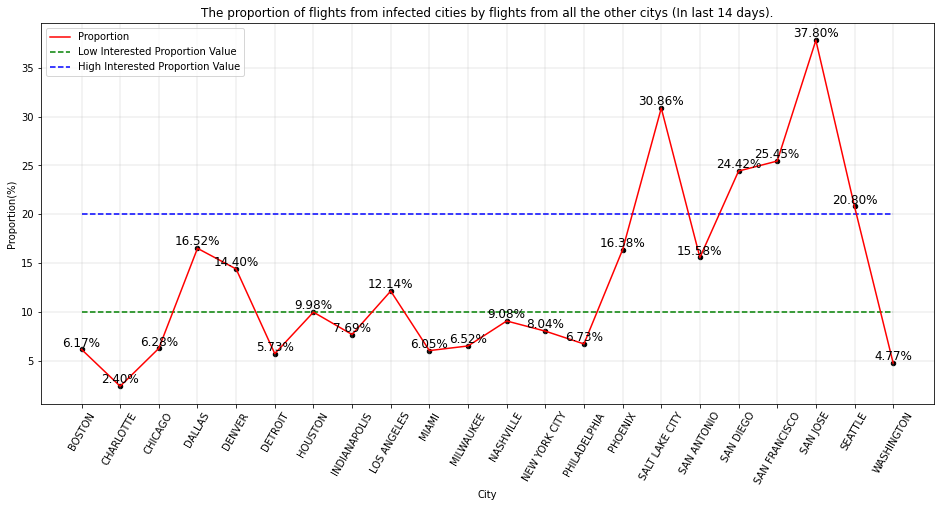

In [0]:
# Draw the line chart

plt.figure(figsize=(16,7))

plt.title("The proportion of flights from infected cities by flights from all the other citys (In last %d days)." % (start))
plt.xlabel("City")
plt.ylabel("Proportion(%)")

plt.plot(city_final, ratio_list, 'r', label='Proportion')
plt.scatter(city_final, ratio_list, marker='o', color='black', s=20)
for a, b in zip(city_final, ratio_list):
  plt.text(a, b, '%.2f%%'%b, ha='center', va='bottom', fontsize=12)
plt.hlines(10, city_final[0], city_final[-1], colors = "g", linestyles = "dashed", label='Low Interested Proportion Value')
plt.hlines(20, city_final[0], city_final[-1], colors = "blue", linestyles = "dashed", label='High Interested Proportion Value')

plt.xticks(city_final, city_final, rotation=60)
plt.legend()
plt.grid(linewidth=0.3)
plt.show()

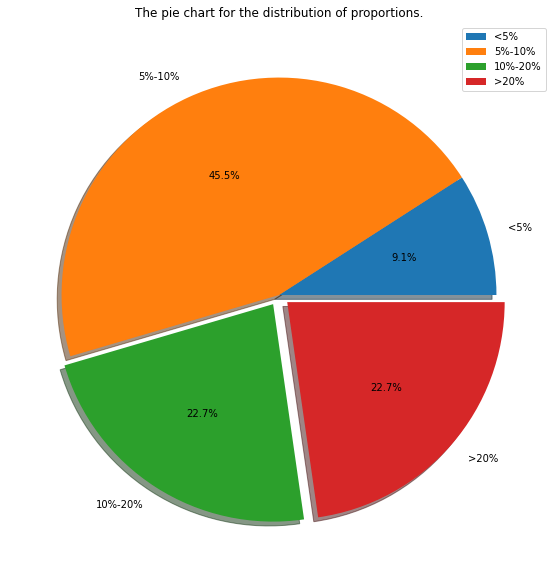

In [0]:
# Draw the pie chart

proportion_labels = ['<5%', '5%-10%', '10%-20%', '>20%']
proportion_data = [0, 0, 0, 0]
explode = (0,0,0.05,0.05)
for i in range(len(ratio_list)):
  if ratio_list[i] < 5:
    proportion_data[0] += 1
  elif ratio_list[i] > 20:
    proportion_data[3] += 1
  elif ratio_list[i] <= 20 and ratio_list[i] >= 10:
    proportion_data[2] += 1
  else:
    proportion_data[1] += 1

plt.figure(figsize=(10,10))
plt.title("The pie chart for the distribution of proportions.")
plt.pie(proportion_data, explode=explode, labels=proportion_labels, autopct='%1.1f%%', shadow=True)
plt.legend()
plt.show()

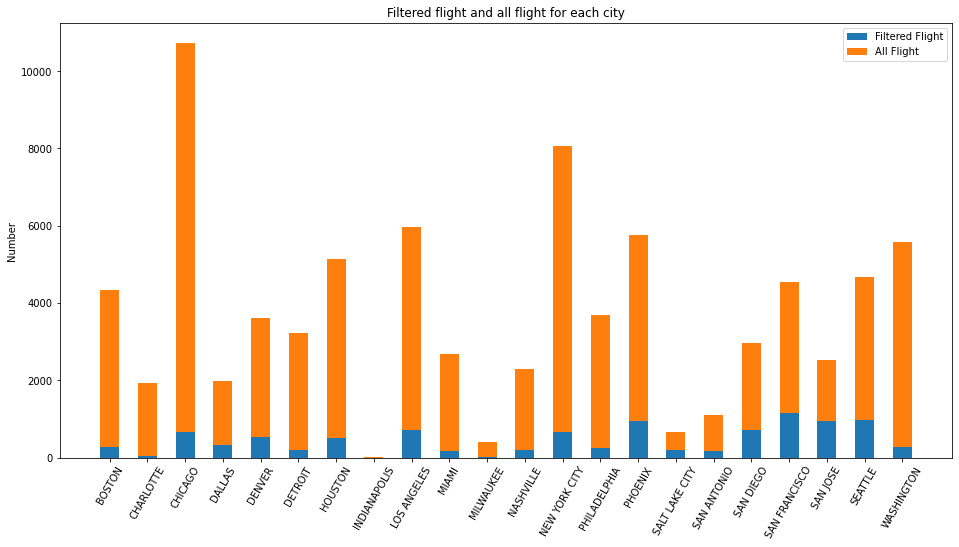

In [0]:
# Draw the bar chart

bar_width = 0.5
fig, ax = plt.subplots(figsize=(16, 8))

flight_difference = []
for i in range(len(flight_all_final)):
  flight_difference.append(flight_all_final[i]-flight_filtered_final[i])
ax.bar(city_final, flight_filtered_final, bar_width, label='Filtered Flight')
ax.bar(city_final, flight_difference, bar_width, bottom = flight_filtered_final, label='All Flight')

ax.set_ylabel('Number')
ax.set_title('Filtered flight and all flight for each city')
ax.legend()

for ax in fig.axes:
  plt.sca(ax)
  plt.xticks(rotation=60)